In [8]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [9]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)

        return actions

In [10]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        rewards = T.tensor(reward).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = rewards + self.gamma*q_next
        print('--start--')
        print(q_pred)
        print(q_target)
        print('--end--')
        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [11]:
env = gym.make('CartPole-v1')
n_games = 1000
scores = []
eps_history = []

agent = Agent(lr=0.0001, input_dims=env.observation_space.shape,
              n_actions=env.action_space.n)

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        score += reward
        agent.learn(obs, action, reward, obs_)
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f avg score %.1f epsilon %.2f' %
              (score, avg_score, agent.epsilon))
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
#    plot_learning_curve(x, scores, eps_history, filename)

--start--
tensor(0.0360, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.1118, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0334, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.0389, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0377, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.1116, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0411, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.0397, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0385, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.1108, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0504, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.0419, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0153, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1.0148, device='cuda:0', grad_fn=<AddBackward0>)
--end--
--start--
tensor(0.0161, device='cuda:0', grad_fn=<SelectBackward>)
tensor(1

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(x, scores, epsilons, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    plt.savefig(filename)

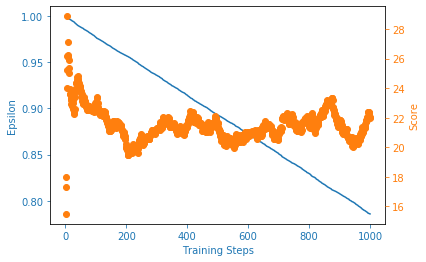

In [13]:
plot_learning_curve(x, scores, eps_history, filename)